In [1]:
import dgl
import torch
import random
import os
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F

from collections import OrderedDict, defaultdict
from dgl.nn.pytorch import GraphConv
from itertools import chain, islice, combinations
from networkx.algorithms.approximation.independent_set import maximum_independent_set as mis
from time import time

# MacOS can have issues with MKL. For more details, see
# https://stackoverflow.com/questions/53014306/error-15-initializing-libiomp5-dylib-but-found-libiomp5-dylib-already-initial
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

Using backend: pytorch


In [2]:
# fix seed to ensure consistent results
seed_value = 1
random.seed(seed_value)        # seed python RNG
np.random.seed(seed_value)     # seed global NumPy RNG
torch.manual_seed(seed_value)  # seed torch RNG

# Set GPU/CPU
TORCH_DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TORCH_DTYPE = torch.float32
print(f'Will use device: {TORCH_DEVICE}, torch dtype: {TORCH_DTYPE}')

Will use device: cpu, torch dtype: torch.float32


/home/aseal/.pyenv/versions/3.8.12/envs/gnns/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
from utils_mc import generate_graph, get_gnn, run_gnn_training, qubo_dict_to_torch, gen_combinations, loss_func

In [4]:
# utils functions for max cut

# helper function to generate Q matrix for Maxi Cut Problem (MC)
def gen_q_dict_mc(nx_G):
    """
    Helper function to generate QUBO matrix for MIS as minimization problem.
    
    Input:
        nx_G: graph as networkx graph object (assumed to be unweigthed)
    Output:
        Q_dic: QUBO as defaultdict
    """

    # Initialize our Q matrix
    Q_dic = defaultdict(int)

    # Update Q matrix for every edge in the graph
    # all off-diagonal terms get penalty
    for (u,v,w) in nx_G.edges(data=True):
        Q_dic[(u, v)] = 2*w['weight']
        Q_dic[(u, u)] -= 1
        Q_dic[(v, v)] -= 1

    return Q_dic

# Calculate results given bitstring and graph definition, includes check for violations
def postprocess_gnn_mc(best_bitstring, nx_graph):
    """
    helper function to postprocess MIS results

    Input:
        best_bitstring: bitstring as torch tensor
    Output:
        size_mc: size of maxcut
    """

    # get bitstring as list
    bitstring_list = list(best_bitstring)

    size_mc = 0

    for (u, v, w) in nx_graph.edges(data=True):
        if bitstring_list[u] != bitstring_list[v]:
            size_mc += w['weight']

    return size_mc

In [5]:
# Graph hypers
n = 100
d = 3
p = None
graph_type = 'weight'

# NN learning hypers #
number_epochs = int(1e5)
learning_rate = 1e-4
PROB_THRESHOLD = 0.5

# Early stopping to allow NN to train to near-completion
tol = 1e-4          # loss must change by more than tol, or trigger
patience = 100    # number early stopping triggers before breaking loop

# Problem size (e.g. graph size)
n = 100

# Establish dim_embedding and hidden_dim values
dim_embedding = int(np.sqrt(n))    # e.g. 10
# dim_embedding = 369
hidden_dim = [ int(dim_embedding/2) ]  # e.g. 5
# hidden_dim = [5]

In [6]:
# Constructs a random d-regular or p-probabilistic graph
nx_graph = generate_graph(n=n, d=d, p=p, graph_type=graph_type, random_seed=seed_value)
# get DGL graph from networkx graph, load onto device
graph_dgl = dgl.from_networkx(nx_graph=nx_graph)
graph_dgl = graph_dgl.to(TORCH_DEVICE)

# Construct Q matrix for graph
q_torch = qubo_dict_to_torch(nx_graph, gen_q_dict_mc(nx_graph), torch_dtype=TORCH_DTYPE, torch_device=TORCH_DEVICE)

Generating weighted d-regular graph with n=100, d=3, seed=1


{(0, 1): Text(0.415708463677982, -0.5128824720402526, '3'),
 (0, 11): Text(0.42460557767356655, -0.25062386887646315, '10'),
 (0, 52): Text(0.5067292147787696, -0.49125114435893774, '2'),
 (1, 44): Text(0.24305182729087588, -0.5246426881549469, '5'),
 (1, 77): Text(0.34086748805860134, -0.5106876813409447, '2'),
 (2, 3): Text(-0.32247545398656713, 0.6057216070758262, '8'),
 (2, 92): Text(-0.7011538754885032, 0.2672077341645847, '8'),
 (2, 45): Text(-0.6762776615934059, 0.6073603623809598, '8'),
 (3, 93): Text(0.09836090428427605, 0.6134742851021449, '7'),
 (3, 83): Text(-0.01543866477593523, 0.606850973507803, '4'),
 (4, 5): Text(-0.3675931426338104, 0.5765767176575138, '2'),
 (4, 70): Text(-0.3592216149097702, 0.32381778690000074, '8'),
 (4, 68): Text(-0.40962838849618577, 0.5636917625831346, '1'),
 (5, 39): Text(-0.2933161426613803, 0.48545624797432885, '7'),
 (5, 71): Text(-0.2778672516721382, 0.6759735751692808, '7'),
 (6, 7): Text(-0.40721222434388177, 0.3002383742366206, '10'),
 

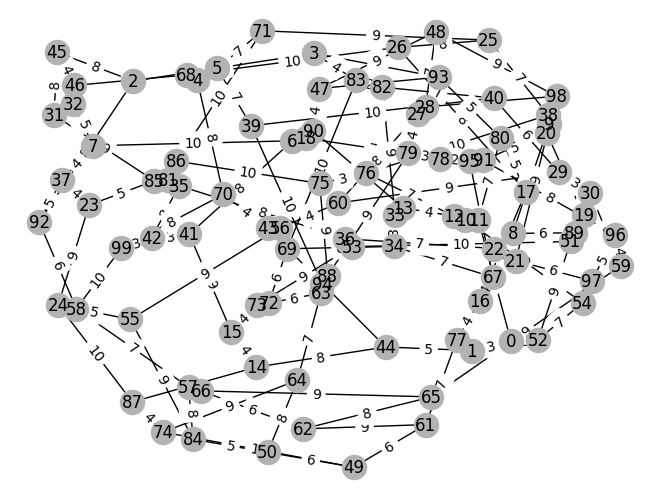

In [7]:
# Visualize graph
pos = nx.kamada_kawai_layout(nx_graph)
nx.draw(nx_graph, pos, with_labels=True, node_color=[[.7, .7, .7]])
labels = nx.get_edge_attributes(nx_graph,'weight')
nx.draw_networkx_edge_labels(next,pos,edge_labels=labels)

In [8]:
# Establish pytorch GNN + optimizer
opt_params = {'lr': learning_rate}
gnn_hypers = {
    'dim_embedding': dim_embedding,
    'hidden_dim': hidden_dim,
    'dropout': 0.0,
    'number_classes': 1,
    'prob_threshold': PROB_THRESHOLD,
    'number_epochs': number_epochs,
    'tolerance': tol,
    'patience': patience
}

net, embed, optimizer = get_gnn(n, gnn_hypers, opt_params, TORCH_DEVICE, TORCH_DTYPE)

# For tracking hyperparameters in results object
gnn_hypers.update(opt_params)

In [9]:
print('Running GNN...')
gnn_start = time()

_, epoch, final_bitstring, best_bitstring = run_gnn_training(
    q_torch, graph_dgl, net, embed, optimizer, gnn_hypers['number_epochs'],
    gnn_hypers['tolerance'], gnn_hypers['patience'], gnn_hypers['prob_threshold'])

gnn_time = time() - gnn_start

Running GNN...
Epoch: 0, Loss: 324.84600830078125


Epoch: 1000, Loss: 269.1744079589844
Epoch: 2000, Loss: 226.5616455078125
Epoch: 3000, Loss: 190.02020263671875
Epoch: 4000, Loss: 160.3633575439453
Epoch: 5000, Loss: 135.32528686523438
Epoch: 6000, Loss: 113.25031280517578
Epoch: 7000, Loss: 94.95183563232422
Epoch: 8000, Loss: 79.37174987792969
Epoch: 9000, Loss: 66.00270080566406
Epoch: 10000, Loss: 54.77973556518555
Epoch: 11000, Loss: 45.350616455078125
Epoch: 12000, Loss: 37.44447708129883
Epoch: 13000, Loss: 30.87192726135254
Epoch: 14000, Loss: 25.356176376342773
Epoch: 15000, Loss: 20.752304077148438
Epoch: 16000, Loss: 16.884077072143555
Epoch: 17000, Loss: 13.68912410736084
Epoch: 18000, Loss: 11.115942001342773
Epoch: 19000, Loss: 8.986272811889648
Epoch: 20000, Loss: 7.260448455810547
Epoch: 21000, Loss: 5.861419200897217
Epoch: 22000, Loss: 4.731507301330566
Epoch: 23000, Loss: 3.8199098110198975
Epoch: 24000, Loss: 3.07224178314209
Epoch: 25000, Loss: 2.463524580001831
Epoch: 26000, Loss: 1.980140209197998
Epoch: 27000,

In [10]:
final_loss = loss_func(final_bitstring.float(), q_torch)
final_bitstring_str = ','.join([str(x) for x in final_bitstring])

# Process bitstring reported by GNN
size_mc = postprocess_gnn_mc(best_bitstring, nx_graph)
gnn_tot_time = time() - gnn_start

print(f'MacxCut found by GNN is {size_mc}')
print(f'Took {round(gnn_tot_time, 3)}s, model training took {round(gnn_time, 3)}s')

MacxCut found by GNN is 687
Took 593.648s, model training took 593.596s


{(0, 1): Text(-0.18032786885245894, -0.6147540983606558, '3'),
 (0, 11): Text(-0.18032786885245894, -0.5532786885245902, '10'),
 (0, 52): Text(-0.18032786885245894, -0.29713114754098363, '2'),
 (1, 44): Text(-0.18032786885245894, -0.32355478861087145, '5'),
 (1, 77): Text(-0.18032786885245894, -0.12942191544434858, '2'),
 (2, 3): Text(-0.18032786885245894, -0.5883304572907679, '8'),
 (2, 92): Text(-0.18032786885245894, -0.02480586712683347, '8'),
 (2, 45): Text(-0.18032786885245894, -0.33218291630716135, '8'),
 (3, 93): Text(-0.18032786885245894, -0.02210957722174295, '7'),
 (3, 83): Text(-0.18032786885245894, -0.07064279551337366, '4'),
 (4, 5): Text(-0.18032786885245894, -0.56190681622088, '2'),
 (4, 70): Text(-0.18032786885245894, -0.15746333045729075, '8'),
 (4, 68): Text(-0.18032786885245894, -0.17364106988783434, '1'),
 (5, 39): Text(-0.18032786885245894, -0.34674288179465057, '7'),
 (5, 71): Text(-0.18032786885245894, -0.1418248490077653, '7'),
 (6, 7): Text(-0.18032786885245894

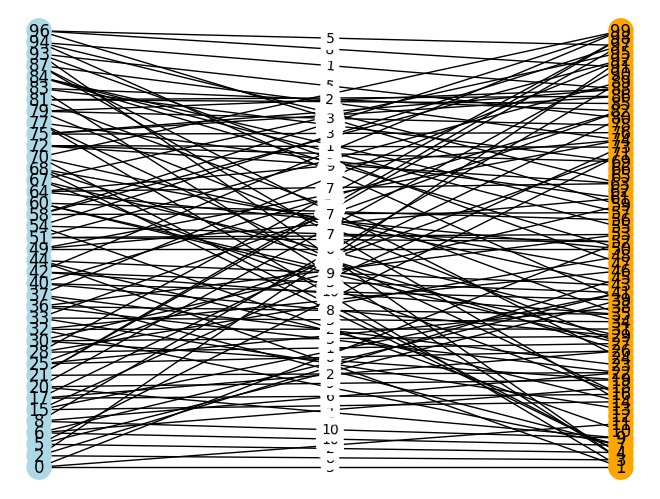

In [13]:
# Visualize result
# Note no light-blue nodes are connected by an edge
pos = nx.drawing.layout.bipartite_layout(nx_graph,set([node for node, entry in enumerate(best_bitstring) if entry == 1]))
color_map = ['orange' if (best_bitstring[node]==0) else 'lightblue' for node in nx_graph.nodes]
nx.draw(nx_graph, pos, with_labels=True, node_color=color_map)
labels = nx.get_edge_attributes(nx_graph,'weight')
nx.draw_networkx_edge_labels(next,pos,edge_labels=labels)